In [3]:
import numpy as np
import igraph
from transformers import pipeline
import colorsys
import matplotlib.pyplot as plt




In [4]:
class roberta_stance_model():
    def __init__(self, input_mode):
        self.model = pipeline("text-classification", model="roberta-large-mnli")
        self.label_dict = {'ENTAILMENT': 1,'CONTRADICTION': -1, "NEUTRAL": 0}
        self.input_mode = input_mode
    def forward(self, x:list[tuple[str,str]]): # 'list' or 'dict'
        output_label = None
        if self.input_mode == "list":
            input = [i[0] + " " + i[1] for i in x]
            output_probs  = self.model(input, top_k=None)
            output_label =  [self.label_dict[x[0]['label']] for x in output_probs]
        elif self.input_mode == "dict":
            input = [{"text":i[0] , "text_pair": i[1]} for i in x]
            output_probs  = self.model(input, top_k=None)
            output_label =  [self.label_dict[x[0]['label']] for x in output_probs]
        return output_probs, output_label

In [5]:
import numpy as np
import igraph
import colorsys
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Dict, Any

class Discourse():
    def __init__(self, stance_model):
        self.discourse_history = []
        self.stance_graph = igraph.Graph(directed=True)
        self.stance_graph.vs["v_id"] = []
        self.stance_graph.vs["membership"] = []
        self.stance_graph.vs["statement"] = []  # Store statements for debugging
        self.stance_model = stance_model
        self.no_stance_update_vertex_idx = 0
        self.no_edges = 0
        
        # Cache for performance
        self._in_degree_cache = {}
        self._cache_valid = False

    def add_statements_vertices(self, statements: List[Tuple[int, str]]):
        """Add new statements to the discourse graph."""
        if not statements:
            return
            
        no_statements = len(statements)
        self.discourse_history.extend(statements)
        start_vertex_idx = len(self.stance_graph.vs)
        
        # Prepare new vertex attributes
        new_vertex_ids = np.arange(start_vertex_idx, start_vertex_idx + no_statements)
        new_vertex_membership = [user for user, statement in statements]
        new_vertex_statements = [statement for user, statement in statements]
        
        # Add vertices with attributes
        self.stance_graph.add_vertices(no_statements)
        
        # Batch attribute assignment - FIX: Handle empty graph case
        if start_vertex_idx == 0:
            # First vertices
            self.stance_graph.vs["v_id"] = new_vertex_ids.tolist()
            self.stance_graph.vs["membership"] = new_vertex_membership
            self.stance_graph.vs["statement"] = new_vertex_statements
        else:
            # Append to existing attributes
            self.stance_graph.vs["v_id"] += new_vertex_ids.tolist()
            self.stance_graph.vs["membership"] += new_vertex_membership
            self.stance_graph.vs["statement"] += new_vertex_statements
        
        # Invalidate cache
        self._cache_valid = False

    def update_stance_graph_edges(self, batch_size: Optional[int] = None):
        """Update edges with stance detection, with optional batching for large graphs."""
        start_vertex_idx = self.no_stance_update_vertex_idx
        end_vertex_idx = len(self.discourse_history)

        if start_vertex_idx >= end_vertex_idx:
            return

        if start_vertex_idx == 0:
            # Initial full graph construction
            v = np.arange(start_vertex_idx, end_vertex_idx)
            v1, v2 = np.meshgrid(v, v, indexing="ij")
            mask = v1 != v2  # Exclude self-loops
            new_to_old_edges = list(zip(v1[mask], v2[mask]))
            
            if batch_size and len(new_to_old_edges) > batch_size:
                self._process_edges_batched(new_to_old_edges, [])
            else:
                # FIX: Only need one direction for initial graph
                edge_stances, _ = self.get_stance(new_to_old_edges)
                self.add_edges(new_to_old_edges, edge_stances)
        else:
            # Incremental update - only connect new vertices to existing ones
            new_vertices = np.arange(start_vertex_idx, end_vertex_idx)
            old_vertices = np.arange(0, start_vertex_idx)

            if len(new_vertices) == 0 or len(old_vertices) == 0:
                return

            v1, v2 = np.meshgrid(new_vertices, old_vertices, indexing="ij")
            new_to_old_edges = list(zip(v1.ravel(), v2.ravel()))
            old_to_new_edges = list(zip(v2.ravel(), v1.ravel()))

            if batch_size and len(new_to_old_edges) > batch_size:
                self._process_edges_batched(new_to_old_edges, old_to_new_edges)
            else:
                new_to_old_stances, old_to_new_stances = self.get_stance(new_to_old_edges)
                self.add_edges(new_to_old_edges, new_to_old_stances)
                self.add_edges(old_to_new_edges, old_to_new_stances)

        self.no_stance_update_vertex_idx = end_vertex_idx
        self._cache_valid = False

    def _process_edges_batched(self, edges1: List[Tuple[int, int]], edges2: List[Tuple[int, int]]):
        """Process edges in batches to manage memory for large graphs."""
        batch_size = 1000  # Adjust based on your memory constraints
        
        for i in range(0, len(edges1), batch_size):
            batch_edges1 = edges1[i:i + batch_size]
            
            if edges2:  # Only if we have reverse edges
                batch_edges2 = edges2[i:i + batch_size]
                stances1, stances2 = self.get_stance(batch_edges1)
                self.add_edges(batch_edges1, stances1)
                self.add_edges(batch_edges2, stances2)
            else:
                stances1, _ = self.get_stance(batch_edges1)
                self.add_edges(batch_edges1, stances1)

    def get_stance(self, edges: List[Tuple[int, int]]) -> Tuple[List[int], List[int]]:
        """Get stance relationships between statements."""
        if not edges:
            return [], []

        # Build statement pairs - FIX: Handle index errors
        try:
            statements = [
                (self.discourse_history[i][1], self.discourse_history[j][1]) 
                for i, j in edges
            ]
        except IndexError as e:
            print(f"Error accessing discourse history: {e}")
            return [0] * len(edges), [0] * len(edges)

        # Get stances for both directions
        try:
            edge_probs, edge_stances = self.stance_model.forward(statements)
            reverse_statements = [(b, a) for a, b in statements]
            reverse_edge_probs, reverse_edge_stances = self.stance_model.forward(reverse_statements)
        except Exception as e:
            print(f"Error in stance model: {e}")
            # Return neutral stances as fallback
            edge_stances = [0] * len(edges)
            reverse_edge_stances = [0] * len(edges)

        return edge_stances, reverse_edge_stances

    def add_edges(self, edges: List[Tuple[int, int]], stances: List[int]):
        """Add edges to the graph with stance attributes."""
        if not edges:
            return

        n = len(edges)
        start = self.no_edges
        end = start + n

        # FIX: Properly handle edge attribute assignment
        self.stance_graph.add_edges(edges)
        
        # Set attributes for the newly added edges
        new_edges = self.stance_graph.es[start:end]
        new_edges["stance"] = stances
        new_edges["e_id"] = list(range(start, end))
        
        self.no_edges = end
        self._cache_valid = False

    def get_in_degree(self, 
                     allowed_stances: List[int], 
                     allowed_vertex_membership: List[int] = None,
                     allowed_v_id: List[int] = None,
                     allowed_e_id: List[int] = None) -> List[int]:
        """Get in-degrees for filtered subgraph with caching."""
        # Generate cache key
        cache_key = self._get_cache_key(allowed_stances, allowed_vertex_membership, allowed_v_id, allowed_e_id)
        
        if self._cache_valid and cache_key in self._in_degree_cache:
            return self._in_degree_cache[cache_key]

        # Create filtered subgraph
        subgraph = self._create_filtered_subgraph(
            allowed_stances, allowed_vertex_membership, allowed_v_id, allowed_e_id
        )
        
        in_degrees = subgraph.indegree()
        
        # Cache results
        self._in_degree_cache[cache_key] = in_degrees
        return in_degrees

    def _get_cache_key(self, stances, membership, v_id, e_id):
        """Generate cache key for filtered subgraph queries."""
        return (
            tuple(sorted(stances)) if stances is not None else (),
            tuple(sorted(membership)) if membership is not None else (),
            tuple(sorted(v_id)) if v_id is not None else (),
            tuple(sorted(e_id)) if e_id is not None else ()
        )

    def _create_filtered_subgraph(self, allowed_stances, allowed_vertex_membership, allowed_v_id, allowed_e_id):
        """Create filtered subgraph based on constraints."""
        if self.stance_graph.vcount() == 0:
            return igraph.Graph(directed=True)

        # Default to all elements if not specified
        if allowed_v_id is None:
            allowed_v_id = list(range(len(self.stance_graph.vs)))
        if allowed_e_id is None:
            allowed_e_id = list(range(self.no_edges))
        if allowed_vertex_membership is None:
            allowed_vertex_membership = list(set(self.stance_graph.vs["membership"]))

        # Vertex filter - FIX: Use proper igraph filtering
        vertex_indices = [
            v.index for v in self.stance_graph.vs 
            if v['membership'] in allowed_vertex_membership and v.index in allowed_v_id
        ]
        
        if not vertex_indices:
            return igraph.Graph(directed=True)

        subgraph = self.stance_graph.subgraph(vertex_indices)

        # Edge filter - FIX: Handle case where subgraph has no edges
        if subgraph.ecount() == 0:
            return subgraph

        edge_indices = [
            e.index for e in subgraph.es 
            if e['stance'] in allowed_stances and e['e_id'] in allowed_e_id
        ]

        if not edge_indices:
            # Return graph with no edges but same vertices
            result = subgraph.copy()
            result.delete_edges(result.es)
            return result

        return subgraph.subgraph_edges(edge_indices, delete_vertices=False)

    def get_community_metrics(self) -> Dict[Any, Dict[str, float]]:
        """Calculate community-level metrics."""
        if self.stance_graph.vcount() == 0:
            return {}
            
        membership_groups = {}
        for v in self.stance_graph.vs:
            membership = v['membership']
            if membership not in membership_groups:
                membership_groups[membership] = []
            membership_groups[membership].append(v.index)
        
        metrics = {}
        for membership, vertices in membership_groups.items():
            subgraph = self.stance_graph.subgraph(vertices)
            if subgraph.vcount() > 0:
                in_degrees = subgraph.indegree()
                avg_in_degree = np.mean(in_degrees) if in_degrees else 0
                metrics[membership] = {
                    'size': subgraph.vcount(),
                    'internal_edges': subgraph.ecount(),
                    'avg_in_degree': avg_in_degree,
                    'density': subgraph.density()
                }
        
        return metrics

    def plot_stance_graph(self,
                         allowed_stances: List[int],
                         allowed_vertex_membership: List[int] = None,
                         allowed_v_id: List[int] = None,
                         allowed_e_id: List[int] = None,
                         layout_algorithm: str = "fr",
                         vertex_size: int = 40,
                         figsize: Tuple[int, int] = (600, 600)):
        """Plot the stance graph with filtering options."""
        subgraph = self._create_filtered_subgraph(
            allowed_stances, allowed_vertex_membership, allowed_v_id, allowed_e_id
        )

        if subgraph.vcount() == 0:
            print("No vertices to plot after filtering")
            return

        # Vertex colors by membership
        unique_memberships = list(set(subgraph.vs["membership"]))
        color_map = self._get_color_map(unique_memberships)
        vertex_colors = [color_map[m] for m in subgraph.vs["membership"]]

        # Edge colors by stance - FIX: Handle case with no edges
        if subgraph.ecount() > 0:
            stance_colors = {1: "green", 0: "gray", -1: "red"}
            edge_colors = [stance_colors.get(s, "black") for s in subgraph.es["stance"]]
        else:
            edge_colors = []

        # Layout
        try:
            layout = subgraph.layout(layout_algorithm)
        except Exception as e:
            print(f"Layout algorithm failed: {e}, using random layout")
            layout = subgraph.layout("random")

        # Plot
        try:
            igraph.plot(
                subgraph,
                layout=layout,
                vertex_color=vertex_colors,
                vertex_size=vertex_size,
                edge_color=edge_colors,
                vertex_label=[f"{v['v_id']}" for v in subgraph.vs],
                bbox=figsize,
                margin=50
            )
            plt.show()
        except Exception as e:
            print(f"Plotting failed: {e}")

    def _get_color_map(self, memberships: List[int]) -> Dict[int, Tuple[float, float, float]]:
        """Generate distinct colors for memberships."""
        n = len(memberships)
        color_map = {}
        for i, membership in enumerate(memberships):
            r, g, b = colorsys.hsv_to_rgb(i / max(n, 1), 0.75, 0.95)
            color_map[membership] = (r, g, b)
        return color_map

    def save_graph(self, filename: str):
        """Save graph to file."""
        try:
            self.stance_graph.write_pickle(filename)
        except Exception as e:
            print(f"Error saving graph: {e}")

    def load_graph(self, filename: str):
        """Load graph from file."""
        try:
            self.stance_graph = igraph.Graph.Read_Pickle(filename)
            # Update counters
            self.no_stance_update_vertex_idx = len(self.stance_graph.vs)
            self.no_edges = len(self.stance_graph.es)
            # Rebuild discourse history from vertex attributes
            self.discourse_history = [
                (self.stance_graph.vs[i]["membership"], self.stance_graph.vs[i]["statement"])
                for i in range(len(self.stance_graph.vs))
            ]
            self._cache_valid = False
        except Exception as e:
            print(f"Error loading graph: {e}")

    def get_graph_info(self) -> Dict[str, Any]:
        """Get basic information about the current graph state."""
        return {
            "vertices": self.stance_graph.vcount(),
            "edges": self.stance_graph.ecount(),
            "statements": len(self.discourse_history),
            "unique_users": len(set(self.stance_graph.vs["membership"])),
            "last_update_vertex": self.no_stance_update_vertex_idx
        }

In [6]:

class FallacyChecker():
    def __init__(self, stance_graph: igraph.Graph):
        self.stance_graph = stance_graph
    
    def get_cycle(self, allowed_vertex_membership: list[int], allowed_stances: list[int]) -> tuple[list[tuple], list[tuple]]:
        membership_subgraph = self.stance_graph.subgraph(
            self.stance_graph.vs.select(membership_in=allowed_vertex_membership)
        )

        stance_subgraph = membership_subgraph.subgraph_edges(
            membership_subgraph.es.select(stance_in=allowed_stances),
            delete_vertices=True
        )

        # Pre-extract once (CRITICAL for speed)
        edgelist = stance_subgraph.get_edgelist()      # list[(v1, v2)]
        v_ids = stance_subgraph.vs["v_id"]             # vertex id mapping
        e_ids = stance_subgraph.es["e_id"]             # edge id mapping

        basis_cycles_edge_idx = stance_subgraph.minimum_cycle_basis()

        basis_cycle_edges_id = []
        basis_cycle_vertices_id = []

        # Fast loop (no repeated igraph calls)
        for edge_cycle in basis_cycles_edge_idx:
            temp_edge_id = []
            temp_vertices = set()

            for eidx in edge_cycle:
                v1, v2 = edgelist[eidx]
                temp_vertices.add(v_ids[v1])
                temp_vertices.add(v_ids[v2])
                temp_edge_id.append(e_ids[eidx])

            basis_cycle_edges_id.append(temp_edge_id)
            basis_cycle_vertices_id.append(tuple(temp_vertices))

        return basis_cycle_edges_id, basis_cycle_vertices_id

    
    def get_contradiction(self, allowed_vertex_membership: list[int]):
        allowed_membership = set(allowed_vertex_membership)

        # Pre-extract attributes once (critical)
        v_membership = self.stance_graph.vs["membership"]
        v_ids        = self.stance_graph.vs["v_id"]
        e_stance     = self.stance_graph.es["stance"]
        edgelist     = self.stance_graph.get_edgelist()

        contradiction_vertices_id = []

        # Single pass over all edges
        for eidx, (u, v) in enumerate(edgelist):
            if e_stance[eidx] != -1:
                continue
            if v_membership[u] not in allowed_membership: continue
            if v_membership[v] not in allowed_membership: continue

            contradiction_vertices_id.append((v_ids[u], v_ids[v]))

        return contradiction_vertices_id



In [18]:
from debate_datasets import Ethix_data
Ethix_dataset = Ethix_data(r"C:\All Codes\BTP\New_Igraph\Ethix_dataset.csv")

debate_idx = 12
scheme_list = Ethix_dataset.iloc[debate_idx]["Scheme"]
argument_text = Ethix_dataset.iloc[debate_idx]["Argument"]
print(scheme_list)
print(argument_text)
debate_data = list(zip(scheme_list, argument_text))
print(len(debate_data))
# Create list of tuples [(number, debate_text), ...]
# debate_data = [(num, debate) for num , debate in (scheme_list, debate_text)]


[2, 4, 7, 2, 3, 6, 0, 4, 3, 4, 0, 3, 0, 6, 0, 3, 4, 4, 0, 3, 3, 3, 0, 7, 0, 5, 0, 2, 5, 3, 3, 6, 2, 2, 0, 0, 5, 3, 0, 7, 0, 2, 0, 2, 0, 6, 5, 7, 2, 5, 1, 3, 2, 2]
['If drugs were legalised, the drug trade would be less able to fuel serious crime.', 'Around half of the total income of criminal organisations comes from illicit drug trafficking. Without this, they would lose significant power.', 'The legalisation of alcohol after Prohibition in the US greatly decreased the ability of gangs to make money from alcohol sales.', 'Legalization of drugs would have significant economic benefits for the state and its citizens, rather than criminal gangs.', 'Legalisation would create jobs, which would likely improve employment rates. This would prevent people from turning to crime in order to generate income.', 'Drug legalisation is not necessary for governments to funnel more money into harm reduction and other social programmes, which could equally combat socioeconomic deprivation.', 'Redistribu

In [19]:
print(len(scheme_list))

54


In [20]:
model = roberta_stance_model(input_mode = "list")
d = Discourse(model)

d.add_statements_vertices(debate_data)

d.update_stance_graph_edges()

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [21]:
# print(d.stance_graph)
d.plot_stance_graph([], [1])

In [22]:
import numpy as np
import igraph
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import colorsys
from typing import List, Dict, Any, Optional, Tuple

def plot_stance_graph(stance_graph: igraph.Graph,
                        allowed_stances: List[int] = None,
                        allowed_vertex_membership: List[int] = None,
                        allowed_v_id: List[int] = None,
                        allowed_e_id: List[int] = None,
                        layout_algorithm: str = "fr",
                        vertex_size: int = 30,
                        figsize: Tuple[int, int] = (1000, 1000),
                        show_plot: bool = True,
                        title: str = "Discourse Stance Graph"):
    """
    External function to plot a discourse stance graph with filtering options.
    
    Args:
        stance_graph: igraph.Graph object with discourse data
        allowed_stances: List of stance values to include (-1, 0, 1)
        allowed_vertex_membership: List of membership IDs to include
        allowed_v_id: List of vertex IDs to include
        allowed_e_id: List of edge IDs to include
        layout_algorithm: igraph layout algorithm ('fr', 'kk', 'circle', etc.)
        vertex_size: Size of vertices in plot
        figsize: Figure size as (width, height)
        show_plot: Whether to display the plot
        title: Plot title
    
    Returns:
        matplotlib figure and axes objects if successful, None otherwise
    """
    
    def create_filtered_subgraph(graph, stances, membership, v_id, e_id):
        """Helper function to create filtered subgraph."""
        if graph.vcount() == 0:
            return igraph.Graph(directed=True)

        # Default to all elements if not specified
        if v_id is None:
            v_id = list(range(len(graph.vs)))
        if e_id is None:
            e_id = list(range(len(graph.es)))
        if membership is None:
            membership = list(set(graph.vs["membership"]))
        if stances is None:
            stances = [-1, 0, 1]

        # Vertex filter
        vertex_indices = [
            v.index for v in graph.vs 
            if v['membership'] in membership and v.index in v_id
        ]
        
        if not vertex_indices:
            return igraph.Graph(directed=True)

        subgraph = graph.subgraph(vertex_indices)

        # Edge filter
        if subgraph.ecount() == 0:
            return subgraph

        edge_indices = [
            e.index for e in subgraph.es 
            if e['stance'] in stances and e['e_id'] in e_id
        ]

        if not edge_indices:
            result = subgraph.copy()
            result.delete_edges(result.es)
            return result

        return subgraph.subgraph_edges(edge_indices, delete_vertices=False)
    
    def get_color_map(memberships: List[int]) -> Dict[int, Tuple[float, float, float]]:
        """Generate distinct colors for memberships."""
        n = len(memberships)
        color_map = {}
        for i, membership in enumerate(memberships):
            r, g, b = colorsys.hsv_to_rgb(i / max(n, 1), 0.75, 0.95)
            color_map[membership] = (r, g, b)
        return color_map

    # Input validation
    if not isinstance(stance_graph, igraph.Graph):
        raise ValueError("Input must be an igraph.Graph object")
    
    if stance_graph.vcount() == 0:
        print("No vertices in graph to plot")
        return None

    # Create filtered subgraph
    subgraph = create_filtered_subgraph(
        stance_graph, allowed_stances, allowed_vertex_membership, allowed_v_id, allowed_e_id
    )

    if subgraph.vcount() == 0:
        print("No vertices to plot after filtering")
        return None

    print(f"Plotting graph with {subgraph.vcount()} vertices and {subgraph.ecount()} edges")

    # Vertex colors by membership
    unique_memberships = sorted(list(set(subgraph.vs["membership"])))
    color_map = get_color_map(unique_memberships)
    vertex_colors_hex = [to_hex(color_map[m]) for m in subgraph.vs["membership"]]

    # Edge colors by stance
    if subgraph.ecount() > 0:
        stance_colors = {1: "green", 0: "gray", -1: "red"}
        edge_colors = [stance_colors.get(s, "blue") for s in subgraph.es["stance"]]
    else:
        edge_colors = ["gray"]

    # Vertex labels
    vertex_labels = []
    for v in subgraph.vs:
        label = f"v{v['v_id']}"
        if 'statement' in v.attributes() and v['statement']:
            statement = v['statement']
            if len(statement) > 15:
                statement = statement[:12] + "..."
            label += f"\n{statement}"
        vertex_labels.append(label)

    # Choose layout
    try:
        if subgraph.vcount() < 3:
            layout = subgraph.layout("circle")
        elif layout_algorithm == "fr" and subgraph.vcount() > 100:
            print("Large graph detected, using kk layout for better performance")
            layout = subgraph.layout("kk")
        else:
            layout = subgraph.layout(layout_algorithm)
    except Exception as e:
        print(f"Layout algorithm {layout_algorithm} failed: {e}, using grid layout")
        layout = subgraph.layout("grid")

    # Create plot
    try:
        fig, ax = plt.subplots(figsize=(figsize[0]/100, figsize[1]/100))
        
        igraph.plot(
            subgraph,
            target=ax,
            layout=layout,
            vertex_color=vertex_colors_hex,
            vertex_size=vertex_size,
            vertex_label=vertex_labels,
            vertex_label_size=8,
            edge_color=edge_colors,
            edge_width=1.5,
            edge_arrow_size=0.8,
            edge_arrow_width=0.8,
            bbox=figsize,
            margin=100
        )
        
        # Create legends
        legend_elements = []
        for membership in unique_memberships:
            color_hex = to_hex(color_map[membership])
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                            markerfacecolor=color_hex, 
                                            markersize=10, label=f'User {membership}'))
        
        stance_legend_elements = [
            plt.Line2D([0], [0], color='green', lw=3, label='Support (1)'),
            plt.Line2D([0], [0], color='gray', lw=3, label='Neutral (0)'),
            plt.Line2D([0], [0], color='red', lw=3, label='Oppose (-1)')
        ]
        
        ax.legend(handles=legend_elements + stance_legend_elements, 
                 loc='upper left', bbox_to_anchor=(1.05, 1), 
                 title="Legend")
        
        plt.title(f"{title}\n({subgraph.vcount()} vertices, {subgraph.ecount()} edges)")
        plt.tight_layout()
        
        if show_plot:
            plt.show()
        else:
            plt.draw()
            
        return fig, ax
        
    except Exception as e:
        print(f"Plotting failed: {e}")
        import traceback
        traceback.print_exc()
        return None


Plotting graph with 54 vertices and 2862 edges


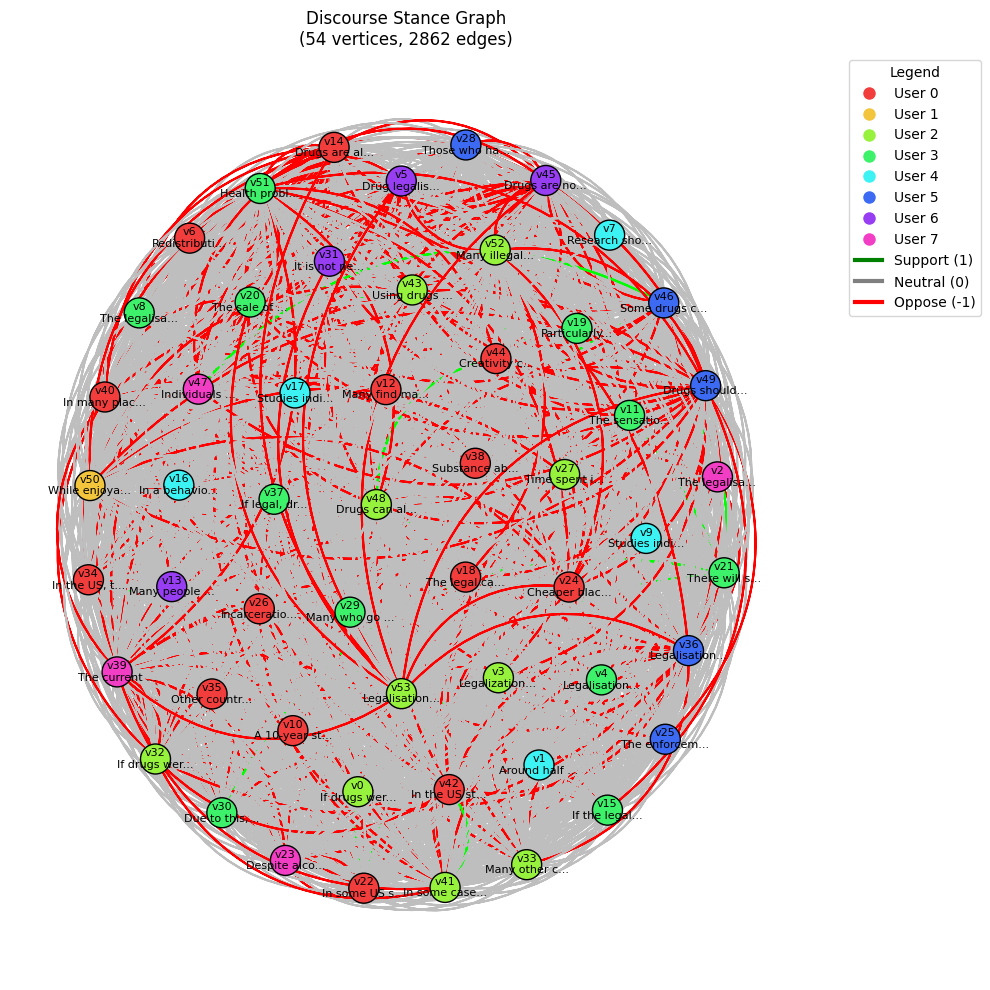

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Discourse Stance Graph\n(54 vertices, 2862 edges)'}>)

In [23]:
plot_stance_graph(d.stance_graph)

Plotting graph with 54 vertices and 11 edges


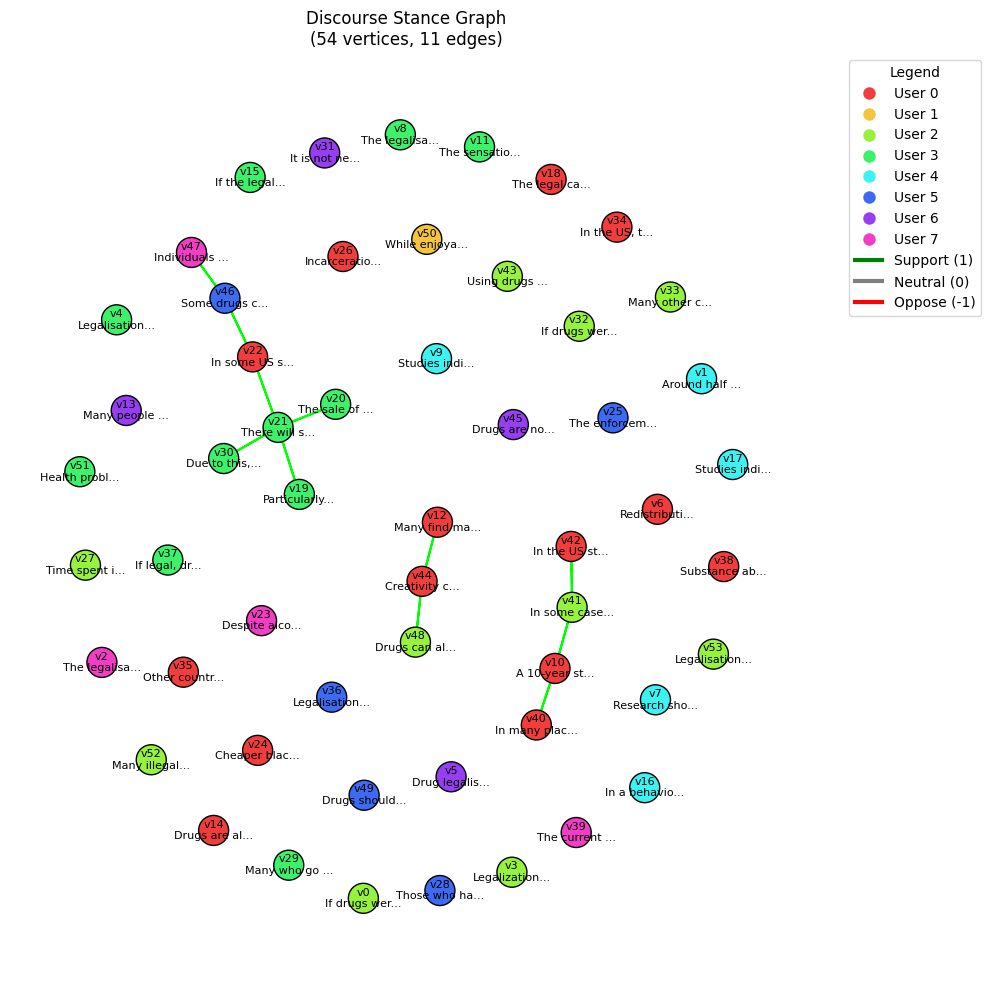

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Discourse Stance Graph\n(54 vertices, 11 edges)'}>)

In [24]:
plot_stance_graph(d.stance_graph, allowed_stances = [1])

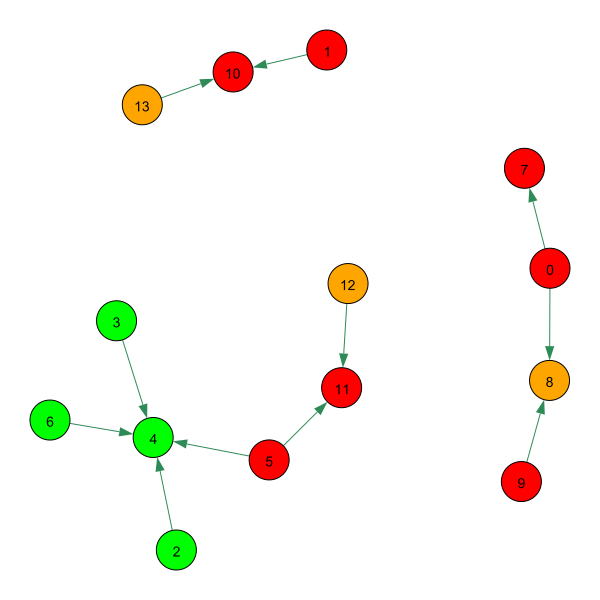

In [25]:
g = d.stance_graph
allowed_stances = [1]
# Assign vertex memberships (for colors)
g = g.subgraph_edges(g.es.select(stance_in = allowed_stances), delete_vertices = True)
# Map memberships to vertex colors
vertex_colors = ['red', 'blue', 'orange', 'green', 'purple']  # example palette
vcolor = [vertex_colors[m % len(vertex_colors)] for m in g.vs['membership']]

# Map stance to edge colors
stance_color_map = {1: 'green', 0: 'gray', -1: 'red'}
aecolor = [stance_color_map[s] for s in g.es['stance']]

# Layout
layout = g.layout('fr')  # Fruchterman-Reingold layout

# Plot
igraph.plot(
    g,
    layout=layout,
    vertex_color=vcolor,
    vertex_size=40,
    edge_color=ecolor,
    vertex_label=[str(i) for i in range(g.vcount())],
    bbox=(600, 600),
    margin=50
)

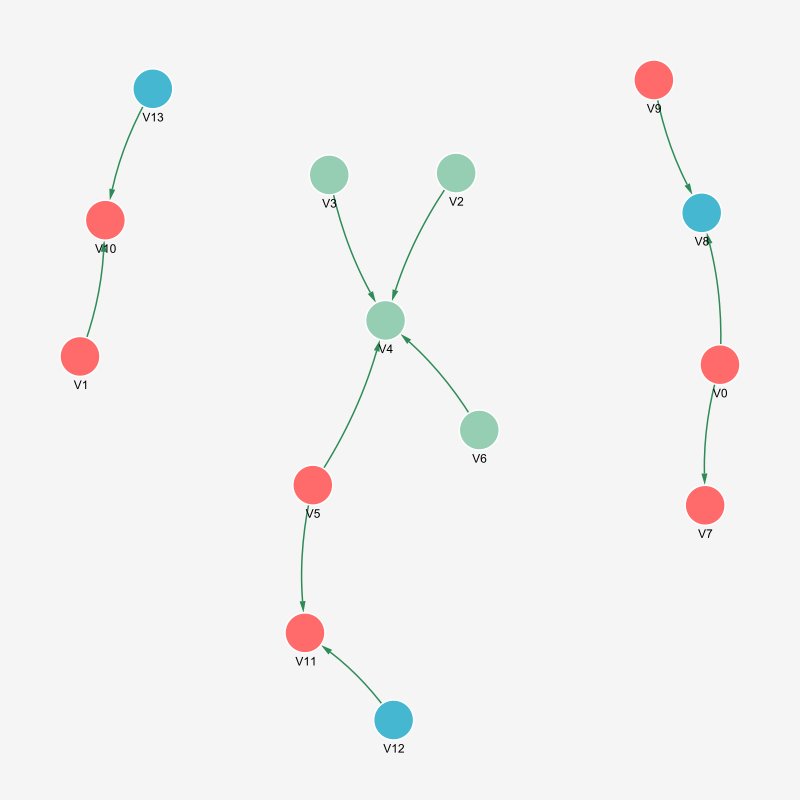

In [26]:
import igraph as ig

g = d.stance_graph
allowed_stances = [1]
# Assign vertex memberships (for colors)
g = g.subgraph_edges(g.es.select(stance_in = allowed_stances), delete_vertices = True)
# Map memberships to vertex colors - more distinct colors
vertex_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']  # modern color palette
vcolor = [vertex_colors[m % len(vertex_colors)] for m in g.vs['membership']]

# Map stance to edge colors
stance_color_map = {1: '#2E8B57', 0: '#808080', -1: '#DC143C'}  # richer colors
ecolor = [stance_color_map[s] for s in g.es['stance']]

# Layout
layout = g.layout('fr')  # Fruchterman-Reingold layout

# Enhanced plotting with thinner, neater edges
visual_style = {
    'layout': layout,
    'vertex_color': vcolor,
    'vertex_size': 40,
    'vertex_frame_width': 1.5,
    'vertex_frame_color': 'white',
    'vertex_label': [f"V{i}" for i in range(g.vcount())],
    'vertex_label_color': 'black',
    'vertex_label_size': 12,
    'vertex_label_dist': 1.2,
    'edge_color': ecolor,
    'edge_width': 1.5,  # Thinner edges
    'edge_arrow_size': 0.8,  # Smaller arrow heads
    'edge_arrow_width': 0.8,
    'edge_curved': 0.1,  # Less curvature for straighter edges
    'bbox': (800, 800),
    'margin': 80,
    'background': '#f5f5f5'
}

# Plot the graph
ig.plot(g, **visual_style)

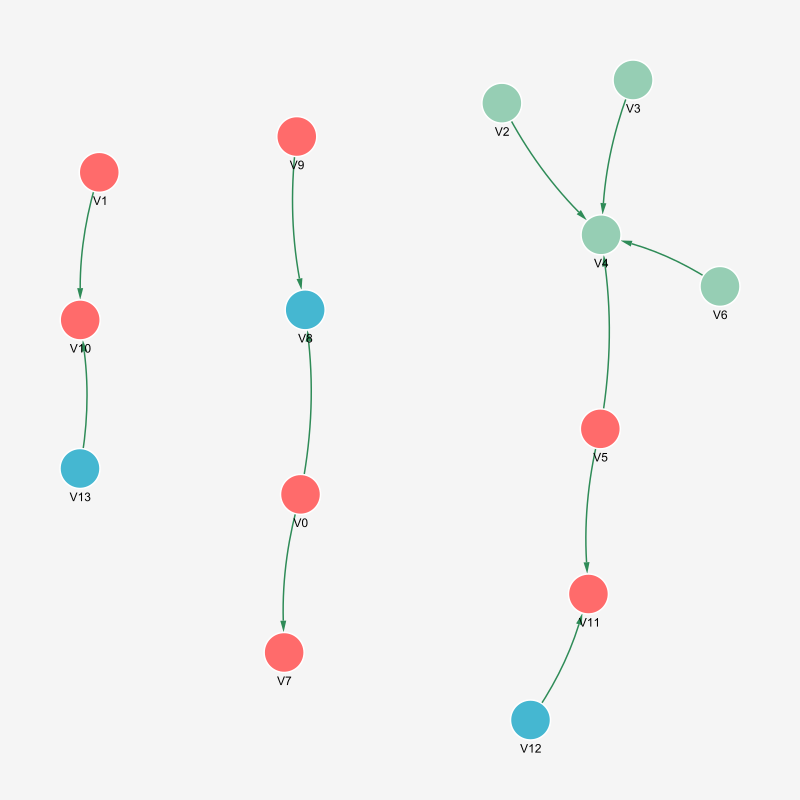

In [27]:
import igraph as ig

g = d.stance_graph
allowed_stances = [1]
# Assign vertex memberships (for colors)
g = g.subgraph_edges(g.es.select(stance_in = allowed_stances), delete_vertices = True)

# Map memberships to vertex colors - more distinct colors
vertex_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']  # modern color palette
vcolor = [vertex_colors[m % len(vertex_colors)] for m in g.vs['membership']]

# Map stance to edge colors
stance_color_map = {1: '#2E8B57', 0: '#808080', -1: '#DC143C'}  # richer colors
ecolor = [stance_color_map[s] for s in g.es['stance']]

# Layout
layout = g.layout('fr')  # Fruchterman-Reingold layout

# Enhanced plotting with thinner, neater edges
visual_style = {
    'layout': layout,
    'vertex_color': vcolor,
    'vertex_size': 40,
    'vertex_frame_width': 1.5,
    'vertex_frame_color': 'white',
    'vertex_label': [f"V{i}" for i in range(g.vcount())],
    'vertex_label_color': 'black',
    'vertex_label_size': 12,
    'vertex_label_dist': 1.2,
    'edge_color': ecolor,
    'edge_width': 1.5,  # Thinner edges
    'edge_arrow_size': 0.8,  # Smaller arrow heads
    'edge_arrow_width': 0.8,
    'edge_curved': 0.1,  # Less curvature for straighter edges
    'bbox': (800, 800),
    'margin': 80,
    'background': '#f5f5f5'
}

# Plot the graph
ig.plot(g, **visual_style)